<a href="https://colab.research.google.com/github/eddiechn/CatOrDog/blob/main/Multi_Animal_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries - data science
import numpy as np
import pandas as pd
import tensorflow as tf
import random


# import libraries - visualization
import matplotlib.pyplot as plt

# import libraries - system
import os
from pathlib import Path


In [2]:
!pip install opendatasets

In [2]:
# seeding everyting to reproduce results for future cases
def seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed()


In [3]:
# data
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [5]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/alessiocorrado99/animals10/data?select=raw-img')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: eddiechn1
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10


100%|██████████| 586M/586M [00:06<00:00, 93.2MB/s]


In [4]:
import sys
sys.path.append('/content/animals10') ## sys.path list of directories to look at when import is invoked
from translate import translate
print(translate)

{'cane': 'dog', 'cavallo': 'horse', 'elefante': 'elephant', 'farfalla': 'butterfly', 'gallina': 'chicken', 'gatto': 'cat', 'mucca': 'cow', 'pecora': 'sheep', 'scoiattolo': 'squirrel', 'dog': 'cane', 'elephant': 'elefante', 'butterfly': 'farfalla', 'chicken': 'gallina', 'cat': 'gatto', 'cow': 'mucca', 'spider': 'ragno', 'squirrel': 'scoiattolo'}


In [5]:
dataset_dir = 'animals10/raw-img'

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    batch_size = BATCH_SIZE,
    image_size = IMG_SIZE,
    label_mode='int'
)

Found 26179 files belonging to 10 classes.


In [7]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [8]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

In [9]:
directory = Path(dataset_dir)
for animal in directory.iterdir():
  if animal.is_dir():
    for img in animal.iterdir():
      try:
          PIL.Image.open(img)
      except UnidentifiedImageError:
          os.remove(img)

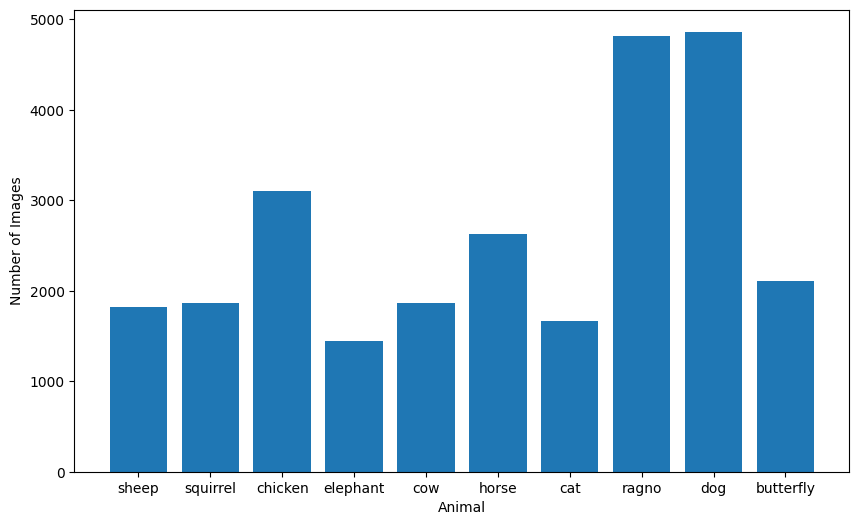

In [ ]:
# distrbution
image_counts = {}
for animal in directory.iterdir():
  if animal.is_dir():
    image_counts[animal.name] = len(list(animal.iterdir()))

labels = [translate.get(animal, animal) for animal in image_counts.keys()]

plt.figure(figsize=(10, 6))
plt.bar(labels, image_counts.values())
plt.xlabel('Animal')
plt.ylabel('Number of Images')
plt.show()

In [14]:
def get_random_animal(dataset, num_images):
    all_images = []
    all_labels = []
    for images, labels in dataset.take(10):
        all_images.extend(images.numpy())  # Convert tensors to numpy arrays
        all_labels.extend(labels.numpy())  # Convert tensors to numpy arrays

    random_indices = np.random.choice(len(all_images), num_images, replace=False)
    selected_images = [all_images[i] for i in random_indices]
    selected_labels = [all_labels[i] for i in random_indices]

    return np.array(selected_images), np.array(selected_labels)

In [12]:
label_mapping = {
    0: 'dog',
    1: 'horse',
    2: 'elephant',
    3: 'butterfly',
    4: 'chicken',
    5: 'cat',
    6: 'cow',
    7: 'sheep',
    8: 'spider',
    9: 'squirrel'
}

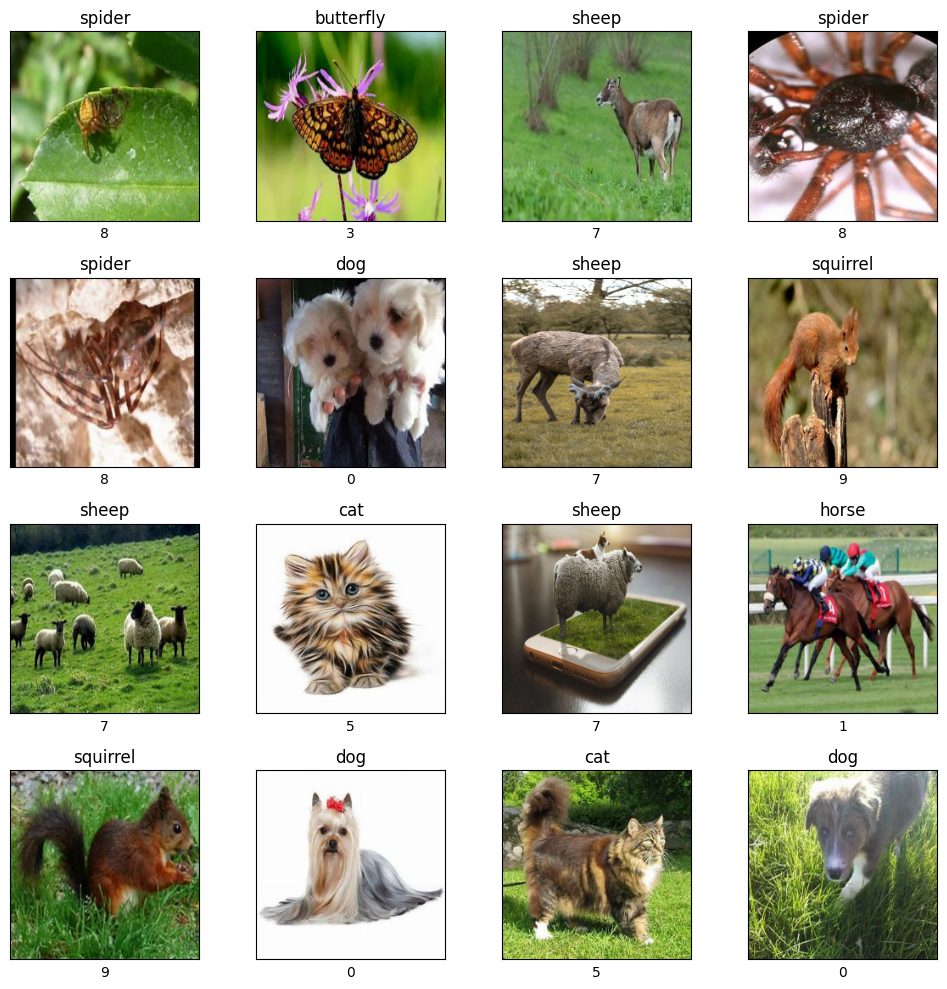

In [15]:
images, labels = get_random_animal(dataset, 16)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].astype('int'))
    ax.set_title(label_mapping[labels[i]])
    ax.set_xlabel(labels[i])

plt.tight_layout()
plt.show()

Preprocessing

In [16]:
VALIDATION_SPLIT = 0.2  # 20% of data for validation
TEST_SPLIT = 0.1  # 10% of data for testing (from the original dataset)

In [20]:
def split_dataset(dataset, val_split=0.2, test_split=0.1, seed=42):
    # Calculate dataset sizes
    total_size = tf.data.experimental.cardinality(dataset).numpy() # number of batches
    val_size = int(total_size * val_split)
    test_size = int(total_size * test_split)
    train_size = total_size - val_size - test_size

    # Shuffle the dataset
    dataset = dataset.shuffle(total_size, seed=seed)

    # Split the dataset
    train_dataset = dataset.take(train_size)
    val_test_dataset = dataset.skip(train_size)
    val_dataset = val_test_dataset.take(val_size)
    test_dataset = val_test_dataset.skip(val_size)

    return train_dataset, val_dataset, test_dataset


In [26]:
# automatic tuning of some parameters. prefetching. improves performance

train_dataset, val_dataset, test_dataset = split_dataset(dataset, VALIDATION_SPLIT, TEST_SPLIT)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [27]:
# Check the sizes of the datasets
print(f"Training dataset size: {tf.data.experimental.cardinality(train_dataset).numpy()}")
print(f"Validation dataset size: {tf.data.experimental.cardinality(val_dataset).numpy()}")
print(f"Test dataset size: {tf.data.experimental.cardinality(test_dataset).numpy()}")
print(f"Total dataset size: {tf.data.experimental.cardinality(dataset).numpy()}")

Training dataset size: 575
Validation dataset size: 163
Test dataset size: 81
Total dataset size: 819


In [ ]:
for images, labels in train_dataset.take(1):
    print(f"Train images shape: {images.shape}")
    print(f"Train labels shape: {labels.shape}")

In [ ]:
dataset

Train the model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Rescaling

In [ ]:
num_classes = 10
IMG_SIZE = (224, 224)

In [ ]:
model = Sequential()
model.add(Rescaling(1./255, input_shape=(224, 224, 3)))
model.add(Conv2D(32, (3,3), 1,  activation='relu' ))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0

In [ ]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
dataset


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
hist = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[tensorboard_callback])

Epoch 1/10
